In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.2'

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

In [4]:
!unzip "/content/drive/MyDrive/yolo4/darknet.zip" -d "/content"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/__MACOSX/darknet/data/images/._H_8424.20-1000_08_639.jpg  
  inflating: /content/darknet/data/images/S_8517.70-1029_08_519.txt  
  inflating: /content/__MACOSX/darknet/data/images/._S_8517.70-1029_08_519.txt  
  inflating: /content/darknet/data/images/H_8202.39-2090_13_294.txt  
  inflating: /content/__MACOSX/darknet/data/images/._H_8202.39-2090_13_294.txt  
  inflating: /content/darknet/data/images/H_9306.30-9000_12_216.txt  
  inflating: /content/__MACOSX/darknet/data/images/._H_9306.30-9000_12_216.txt  
  inflating: /content/darknet/data/images/H_8205.30-0000_10_530.jpg  
  inflating: /content/__MACOSX/darknet/data/images/._H_8205.30-0000_10_530.jpg  
  inflating: /content/darknet/data/images/H_9613.80-0000_03_851.jpg  
  inflating: /content/__MACOSX/darknet/data/images/._H_9613.80-0000_03_851.jpg  
  inflating: /content/darknet/data/images/H_8204.20-0000_21_132.jpg  
  inflating: /content/__MACOSX/darknet/data/images/._H_820

In [6]:
# data 파일 수정 = .txt 지우기 ^^
# cfg 파일 수정
'''
- classes = 38
- 480 x 480
- batch 64 , sub =16
- max_batches 38*1000 = 38000
- 러닝메이트
- 38000**0.8=30400 , 38000*0*.9=34200
- filter 129
'''
# 또 에러 나면 배치 사이즈 64 ~>32 로 줄이기

# 우리가 사용할 YOLOv4의 구조를 살펴보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=480
height=480
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 38000
policy=steps
steps=30400,34200
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activa

In [7]:
cd /content/darknet

/content/darknet


In [8]:
!ln -s /content/drive/MyDrive /content/darknet/mydrive
!ls /content/darknet/mydrive

 정리			       final	       project	      yolo3.ipynb
 211101_object_sbppt.gslides   github_anna     share_120293   yolo4
'Colab Notebooks'	       object_Detect   yolo3


In [9]:
# GPU, OPENCV, LIBSO을 true로 설정
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!apt update
!apt-get install libopencv-dev
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.1 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [912 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu

In [10]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [13]:
from darknet import *

In [14]:
pwd

'/content/darknet'

In [15]:
# YOLOv4 모델을 로드하여보자.
# .txt 지우기 ^^
# 커스텀 모델을 사용할 경우 load_network의 1번째, 3번째 인자를 수정해야 한다.
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/xrayDatas.data", "/content/drive/MyDrive/final/yolov4-custom_best.weights")

In [16]:
# class의 종류 예시
class_names

['Aerosol',
 'Alcohol',
 'Awl',
 'Axe',
 'Bat',
 'Battery',
 'Bullet',
 'Chisel',
 'Electronic cigarettes',
 'Electronic cigarettes(Liquid)',
 'Firecracker',
 'Gun',
 'GunParts',
 'Hammer',
 'HandCuffs',
 'HDD',
 'Knife',
 'Laptop',
 'Lighter',
 'Liquid',
 'Match',
 'MetalPipe',
 'NailClippers',
 'Plier',
 'PrtableGas',
 'Saw',
 'Scissors',
 'Screwdriver',
 'SmartPhone',
 'SolidFuel',
 'Spanner',
 'SSD',
 'SupplymentaryBattery',
 'TabletPC',
 'Thinner',
 'Throwing Knife',
 'USB',
 'ZippoOil']

In [17]:
# class color의 예시
class_colors['HDD']

(154, 212, 34)

In [18]:
# 네트워크의 width와 height을 계산
width = network_width(network)
height = network_height(network)

print(width, height)

480 480


In [19]:
# object detection을 수행하는 darknet_helper 함수를 살펴보자.

def darknet_helper(img, width, height):
  # 이미지를 darknet style로 전처리 -> darknet_image 변수에 저장
  darknet_image = make_image(width, height, 3)
  # input image를 BRG에서 RGB 순서로 변환
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # input image의 size를 512x512로 변환 (network에서 받아들이는 이미지의 크기가 512x512였기 때문에)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # bounding box의 크기를 조정하기 위하여 이미지 크기 비율을 계산 
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width # 원본 이미지 width/ network width
  height_ratio = img_height/height # 원본 이미지 height/ network height

  # darknet stlye로 전처리된 이미지로 모델을 작동시켜 detection을 수행
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # detect_image 함수 실행
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

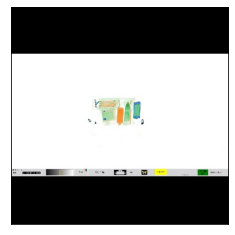

In [21]:
# 이미지 불러오기
input='/content/drive/MyDrive/yolo4/test_images/H_2707.99-1000_01_128.jpg'
image = cv2.imread(input)
#RGB 이미지를 BGR로 변환
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# 이미지 출력
plt.imshow(imagee) 
plt.xticks([]) # x축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.yticks([]) # y축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.show() 

In [22]:
# darknet_helper 함수에 앞서 읽은 이미지와 network height, width를 입력
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)

In [23]:
# detection 결과 확인
detections

[('Aerosol',
  '69.95',
  (277.08782958984375,
   229.70816040039062,
   16.265077590942383,
   38.96242904663086)),
 ('Knife',
  '89.04',
  (240.70181274414062,
   242.81802368164062,
   15.676419258117676,
   40.77021408081055))]

In [24]:
width_ratio, height_ratio

(1.0, 1.0)

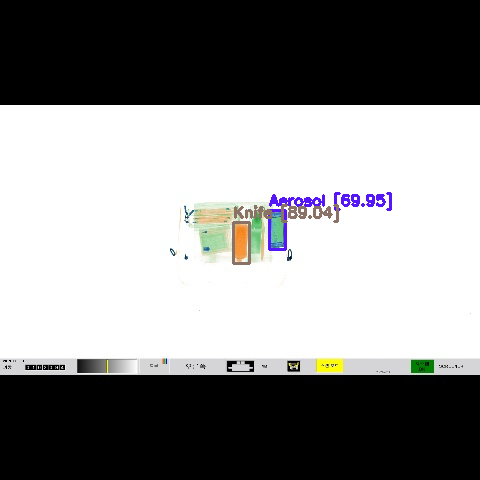

In [25]:
# detection 결과 시각화

for label, confidence, bbox in detections:
  # center x, center y, width, height로 반환 받은 boundary box를 corner 정보 (left, top, right, bottom)로 변환
  left, top, right, bottom = bbox2points(bbox)
  # 앞서 계산한 이미지 비율을 사용하여 boundary box의 크기를 조정
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # boundary box 좌표에 해당하는 사각형을 이미지 위에 그림
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  # 클래스 이름과 confidence level을 사각형 위에 입력
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

# boundary box를 추가한 이미지 출력
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

In [26]:
# JavaScript 객체를 OpenCV 이미지 유형으로 변환
def js_to_image(js_reply):
  """
  파라미터:
          js_reply: JavaScript 객체 (Base64 진법의 문자열)
  반환:
          img:  OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  """

  # 64진법으로 인코딩된 Javascript 객체를 바이트로 디코딩 
  image_bytes = b64decode(js_reply.split(',')[1])
  # 바이트를 넘파이 배열로 변환
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 넘파이 배열을 OpenCV BGR 이미지로 변환
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [27]:
# OpenCV 사각형(Bounding Box) 이미지를 JavaScript 객체로 변환
def bbox_to_bytes(bbox_array):
  """
  파라미터:
          bbox_array: OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  반환:
        바이트: JavaScript 객체 (Base64 진법의 문자열)
  """
  # 넘파일 배열을 PIL(Python Image Library) 이미지로 변환 
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  # 문자열(바이트 배열)을 이진 파일로 읽을 수 있는 BytesIO 객체 생성
  iobuf = io.BytesIO()
  # PIL 이미지 형태의 boundary box를 png 파일로 변환하여 저장 
  bbox_PIL.save(iobuf, format='png')
  # JavaScript 객체 반환
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [28]:
def take_photo(filename='photo.jpg', quality=0.8):

  # 자바스크립트를 사용하여 local webcam에 access 
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // 결과를 resize
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // 클릭하여 이미지 캡쳐
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # YOLO v4 detection 수행

  # javascrip 이미지를 입력
  data = eval_js('takePhoto({})'.format(quality))
  # OpenCV 형식의 이미지로 변환
  img = js_to_image(data) 
  
  # 앞서 정의했던 darknet helper 함수에 웹캠 이미지를 삽입
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # detection을 통해 얻은 boundary boxes를 웹캠 이미지에 표시
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # 이미지를 저장
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


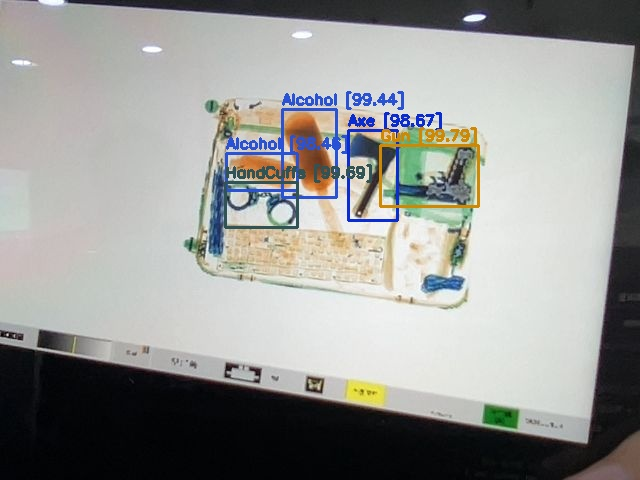

In [29]:
try:
  # 앞서 정의한 take_photo 함수를 실행
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # take photo 결과물을 출력
  display(Image(filename))

  # 에러가 발행했을 실행
except Exception as err:
  # 사용자의 컴퓨터에 웹캠이 없거나 웹캠 접근권한이 없을 때 에러 메시지를 출력
  print(str(err))

In [32]:
# 실시간 영상 스트리밍을 작동시키는 JavaScript 코드
def video_stream():
  js = Javascript('''
    var video;
    var div = null; 
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [36]:
frame.shape

(480, 640, 3)

In [38]:
# 웹캠에서 영상 스트리밍을 시작
video_stream()
# label for video
label_html = 'Capturing...'
# bounding box 초기화 
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # javascript 객체를 OpenCV 이미지로 변환 
    frame = js_to_image(js_reply["img"])
    

    # bounding box를 위한 투명 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 앞서 정의하였던 darknet helper 함수를 실행 
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # detection 결과를 순회하며 결과를 overlay 이미지에 표시
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # bounding box의 overlay를 바이트로 변환
    bbox_bytes = bbox_to_bytes(bbox_array)
    # bounding box를 업데이트하여 다음 프레임이 새로운 overlay를 갖도록 함
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
#